# **Inversión de datos MT desplazados**

In [1]:
# Importar librerías

import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

#MTpy
from mtpy import MT, MTCollection, MTData

#SimPEG
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

matplotlib.rcParams.update({"font.size": 16})
from ipywidgets import interact, widgets
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

In [2]:
# Cargar el archivo
dobs_MT = np.load("../FASE 1/MT/DatosMT.npy", allow_pickle=True).item()

# Extraer las variables
dobs = dobs_MT["dobs"]

In [3]:
# Definir número de frecuencias
num_frequencies = len(dobs) // 2  # Porque hay pares de valores (resistividad, fase)

# Hacer reshape y modificar solo la resistividad aparente
dobs_modificado = dobs.reshape((num_frequencies, 2)).copy()
dobs_modificado[:, 0] *= 1.5  # Multiplicar solo la resistividad aparente por 5

# Aplanar el array de vuelta a la forma original
dobs = dobs_modificado.ravel()

print(dobs)


[ 52.81655085  37.09527215  46.04022489  35.0947962   37.09419849
  33.27538215  29.5255907   32.38840271  23.02590857  33.48126496
  18.06941834  37.56396059  16.19173047  44.63831244  17.40598301
  52.35374103  20.95511239  58.54267737  28.63124671  64.32815991
  43.99048413  68.31520442  70.47386871  66.8762369  100.10544823
  61.7777874  117.81884688  58.66895198 144.99780165  58.65872621
 189.28642115  57.28979637 234.40585359  52.70832816 249.84508036
  47.25734244 235.9077784   44.48293897 225.10056138  44.76210193]


In [4]:
layer_tops = np.r_[0., -500., -1500., -2150., -3650., -5650.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[150., 30, 3., 50., 8., 50.][::-1]
frequencies = np.logspace(-3, 3, 20)
relative_error_rho = 0.01
floor_phase = 0.01

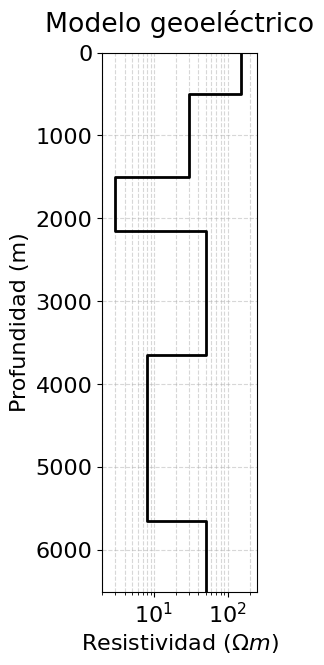

In [5]:
# Graficar el modelo
fig, ax = plt.subplots(figsize=(2, 7))
ax = plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax, color="black", label="Modelo teórico", lw= 2)
ax.set_xlabel(r"Resistividad ($\Omega m$)")
ax.set_ylabel(r"Profundidad (m)")
#ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax.set_ylim(6500, 0)
ax.set_xlim([10**0.3, 10**2.4])
ax.set_title("Modelo geoeléctrico", pad=15)
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil

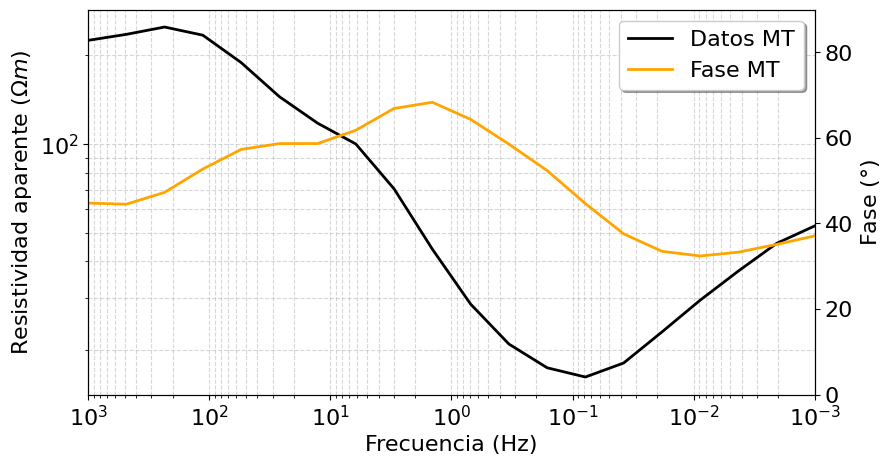

In [6]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0],  color='black', label='Datos MT', lw =2)
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='orange', label='Fase MT',  lw =2)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax.set_xlabel("Frecuencia (Hz)")  
ax.set_xlim(frequencies.max(), frequencies.min())

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='orange', lw = 2)  
ax_1.set_ylim(0, 90)    
ax_1.set_ylabel("Fase ($\degree$)")
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.show()

In [7]:
def run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=0.1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
    ):
    
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(
        mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref,
        mapping=maps.IdentityMap(mesh=mesh_inv)
    )

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_schedule,
        target_misfit,
        save_dictionary
    ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

In [8]:
dz = 20
n_layer = 24
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]
print("El espesor total del modelo será:", layer_thicknesses_inv.sum(), "metros")

El espesor total del modelo será: 6524.737266949234 metros


In [9]:
rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()

rho_0 = 100 #100
rho_ref = 100 #100

output_dict ={}
recovered_model, output_dict = run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=25,
    alpha_s=1e-10,      
    alpha_z=1,
    beta0_ratio=1e2,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1e-2,
)

target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.75e+09  3.26e+07  0.00e+00  3.26e+07    9.06e+06      0              
   1  1.88e+09  1.02e+07  1.71e-03  1.34e+07    6.26e+06      0              
   2  9.39e+08  3.78e+06  3.59e-03  7.15e+06    2.56e+06      0   Skip BFGS  
   3  4.69e+08  1.62e+06  5.06e-03  3.99e+06    1.45e+06      0   Skip BFGS  
   4  2.35e+08  8.45e+05  6.14e-03  2.28e+06    7.62e+05      0   Skip BFGS  
   5  1.17e+08  5.57e+05  6.96e-03  1.37e+06    4.37e+05      0   Skip

In [10]:
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [11]:
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=25, description='iteration', max=25, min=1), RadioButtons(description='s…

[208.44201627 218.36388228 233.94972332 245.55937272 238.79730954
 213.75382014 194.76726212 213.02254604 275.18583657 272.64360026
 113.43120491  41.40199592  48.91033424  38.90326048  47.85428493
  86.89459564   5.8557782    4.04587608  29.90276453  58.76519816
  51.58770348  17.90214806   7.94811048  74.53836205]


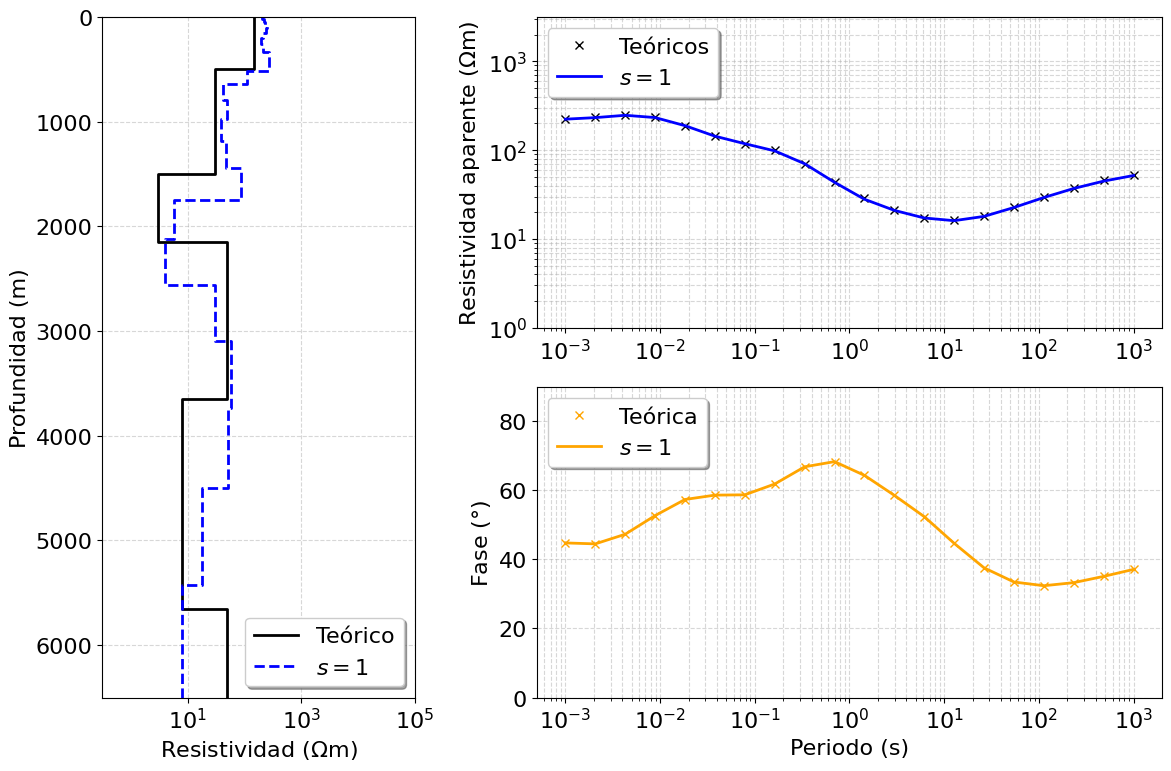

In [12]:
def plot_model_and_measurements(iteration):
    dpred = output_dict[iteration]['dpred']  # Datos predichos
    m = output_dict[iteration]['m']  # Modelo invertido
    print((1./(np.exp(m)))[::-1])
    # Crear la figura y los subgráficos
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1])  # 2 filas, 2 columnas

    # Subgráfico 1: Modelo de resistividades (izquierda)
    ax0 = fig.add_subplot(gs[:, 0])  # Ocupa todas las filas de la primera columna
    plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", label='Teórico', lw=2)
    plot_1d_layer_model(layer_thicknesses_inv[::-1], (1./(np.exp(m)))[::-1], ax=ax0, color="blue", linestyle='--', label='$\mathit{s}=1$', lw=2)
    ax0.grid(True, which="both", linestyle='--', alpha=0.5)
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_xlim([10**-0.5, 10**5])
    ax0.set_ylim(6500, 0)
    ax0.set_ylabel("Profundidad (m)")
    ax0.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

    # Subgráfico 2: Mediciones de resistividad aparente (derecha, arriba)
    ax1 = fig.add_subplot(gs[0, 1])  # Primera fila, segunda columna
    ax1.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 0], 'x', color='k', label='Teóricos', lw=2)
    ax1.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 0], color='blue', label='$\mathit{s}=1$', lw=2)
    ax1.grid(True, which="both", linestyle='--', alpha=0.5)
    ax1.set_ylabel("Resistividad aparente ($\Omega$m)")
    ax1.legend(loc='upper left', frameon=True, shadow=True, fancybox=True)
    ax1.set_ylim([10**0, 10**3.5])

    # Subgráfico 3: Mediciones de fase (derecha, abajo)
    ax2 = fig.add_subplot(gs[1, 1])  # Segunda fila, segunda columna
    ax2.semilogx(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 1], 'x', color='orange', label='Teórica', lw=2)
    ax2.semilogx(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 1], color='orange', label='$\mathit{s}=1$', lw=2)
    ax2.grid(True, which="both", linestyle='--', alpha=0.5)
    ax2.set_xlabel("Periodo (s)")
    ax2.set_ylabel("Fase ($\degree$)")
    ax2.legend(loc='upper left', frameon=True, shadow=True, fancybox=True)
    ax2.set_ylim([0, 90])

    # Ajustar el espaciado entre subgráficos
    plt.tight_layout()

    # Guardar la figura
    filename = "Modelo_y_Mediciones.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')

    plt.show()
    

# Llamar a la función con la última iteración
plot_model_and_measurements(n_iteration)

Calcular el mse logarítmico

In [13]:
modelo_real = np.array([152.59739383, 152.15098892, 149.74963595, 147.84994339, 148.40829225,
                        151.78867116, 158.644144,   164.08404772, 146.60461601,  88.39393166,
                        32.25425748,  25.17490069,  34.07869615,  34.29308427,  24.00075227,
                        4.12391529,   2.99775928,  15.30993888, 25.47956442,  25.36806765,
                        14.61438201,   5.18076453,  74.65630648,  49.36687565])

In [14]:
m = output_dict[iteration]['m']
modelo_pred= ((1./(np.exp(m)))[::-1])
modelo_pred

array([208.44201627, 218.36388228, 233.94972332, 245.55937272,
       238.79730954, 213.75382014, 194.76726212, 213.02254604,
       275.18583657, 272.64360026, 113.43120491,  41.40199592,
        48.91033424,  38.90326048,  47.85428493,  86.89459564,
         5.8557782 ,   4.04587608,  29.90276453,  58.76519816,
        51.58770348,  17.90214806,   7.94811048,  74.53836205])

In [15]:
# Resistividades 

mse1 = np.mean((modelo_real - modelo_pred) ** 2)
# Calcular el RMS
rms1 = np.sqrt(mse1)

print(f"MSE: {mse1}")
print(f"RMS: {rms1}")

MSE: 4696.957845528388
RMS: 68.53435522078243


calcular el mse logaritmico

In [16]:
modelo_reallog = np.log10(modelo_real)
modelo_reallog

modelo_predlog = np.log10(modelo_pred)
modelo_predlog

array([2.31898527, 2.33918081, 2.36912254, 2.39015652, 2.37802943,
       2.32991389, 2.28951596, 2.32842557, 2.43962608, 2.43559531,
       2.05473255, 1.61702128, 1.68940063, 1.589986  , 1.67992083,
       1.93899277, 0.76758462, 0.60701258, 1.47571134, 1.7691202 ,
       1.71254619, 1.25290514, 0.9002639 , 1.87237985])

In [17]:
# Resistividades 

mse2 = np.mean((modelo_reallog - modelo_predlog) ** 2)
# Calcular el RMS
rms2 = np.sqrt(mse2)

print(f"MSE: {mse2}")
print(f"RMS: {rms2}")

MSE: 0.2028403627491505
RMS: 0.4503780220538636
